In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


In [2]:
signalFile=TFile.Open("../sample-0702/sig_bbZZ.root")
backgroundFile=TFile.Open("../sample-0702/bkg_ttbar.root")
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

signal events number before cut is:  75911
background events number before cut is:  6922544


In [ ]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(12,10))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(12,10))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [ ]:
model=load_model('model_4lNN.h5')

In [ ]:
signalNNScore=model.predict(signalArray[:,1:])
backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
cuda.select_device(0)
cuda.close()

In [3]:
GBDT_tt = pickle.load(open("../BDT_model/0716/GBDT_HH_region1_001.pickle.dat", "rb"))
GBDT_zz = pickle.load(open("../BDT_model/0716/GBDT_HH_region1_001.pickle.dat", "rb"))
GBDT_ww = pickle.load(open("../BDT_model/0716/GBDT_HH_region1_001.pickle.dat", "rb"))

In [4]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
signalTTBDTScore=GBDT_tt.predict(BDTSignal)
backgroundTTBDTScore=GBDT_tt.predict(BDTBackground)
signalZZBDTScore=GBDT_zz.predict(BDTSignal)
backgroundZZBDTScore=GBDT_zz.predict(BDTBackground)
signalWWBDTScore=GBDT_ww.predict(BDTSignal)
backgroundWWBDTScore=GBDT_ww.predict(BDTBackground)

[0.9939023  0.9791876  0.69647557 ... 0.66495264 0.93748873 0.9895132 ]


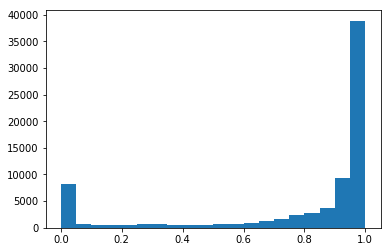

In [5]:
plt.hist(signalTTBDTScore,bins=20)
print(signalTTBDTScore)

In [9]:
signalFile.Close()
backgroundFile.Close()
signalFile=TFile.Open("../sample-0702/sig_bbZZ.root","update")
#backgroundFile=TFile.Open("samples/bkg_ttbar_dilepton.root","update")
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

#bakZZBDTBranch=backgroundTree.Branch("BDT_ZZ",bZZBDT,"BDT_ZZ/F")
#bakWWBDTBranch=backgroundTree.Branch("BDT_WW",bWWBDT,"BDT_WW/F")
#bakTTBDTBranch=backgroundTree.Branch("BDT_TT",bTTBDT,"BDT_TT/F")
#sn=array("f",[0])
#bn=array("f",[0])
#sigBranch=signalTree.Branch("keras_NN",sn,"keras_NN/F")sZZBDT=array("f",[0])
sZZBDT=array("f",[0])
sTTBDT=array("f",[0])
sWWBDT=array("f",[0])
bZZBDT=array("f",[0])
bTTBDT=array("f",[0])
bWWBDT=array("f",[0])
sigZZBDTBranch=signalTree.Branch("BDT_ZZ",sZZBDT,"BDT_ZZ/F")
sigWWBDTBranch=signalTree.Branch("BDT_WW",sWWBDT,"BDT_WW/F")
sigTTBDTBranch=signalTree.Branch("BDT_TT",sTTBDT,"BDT_TT/F")


In [10]:
i=0
for (scoreZZ,scoreTT,scoreWW) in zip(signalZZBDTScore,signalTTBDTScore,signalWWBDTScore):
    i=i+1
    if(i%5000==0):
        print("looping: ",i)
    sZZBDT[0]=scoreZZ
    sWWBDT[0]=scoreWW
    sTTBDT[0]=scoreTT
    sigZZBDTBranch.Fill()
    sigWWBDTBranch.Fill()
    sigTTBDTBranch.Fill()
    
signalTree.Write()
signalFile.Write()
signalFile.Close()

looping:  5000
looping:  10000
looping:  15000
looping:  20000
looping:  25000
looping:  30000
looping:  35000
looping:  40000
looping:  45000
looping:  50000
looping:  55000
looping:  60000
looping:  65000
looping:  70000
looping:  75000


In [ ]:
i=0
for (scoreZZ,scoreTT,scoreWW) in zip(backgroundZZBDTScore,backgroundTTBDTScore,backgroundWWBDTScore):
    i=i+1
    if(i%5000==0):
        print("looping: ",i)
    bZZBDT[0]=scoreZZ
    bWWBDT[0]=scoreWW
    bTTBDT[0]=scoreTT
    bakZZBDTBranch.Fill()
    bakWWBDTBranch.Fill()
    bakTTBDTBranch.Fill()
    
backgroundTree.Write()
backgroundFile.Write()
backgroundFile.Close()